In [1]:
import tensorflow as tf
import numpy as np

# установим сид для лучшей воспроизводимости
np.random.seed(17)
tf.random.set_seed(17)

In [2]:
# загрузим датасет с помощью Keras
# нам необходимы только входные данные (без лейблов)

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# соединим и отнормируем данные

all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step 


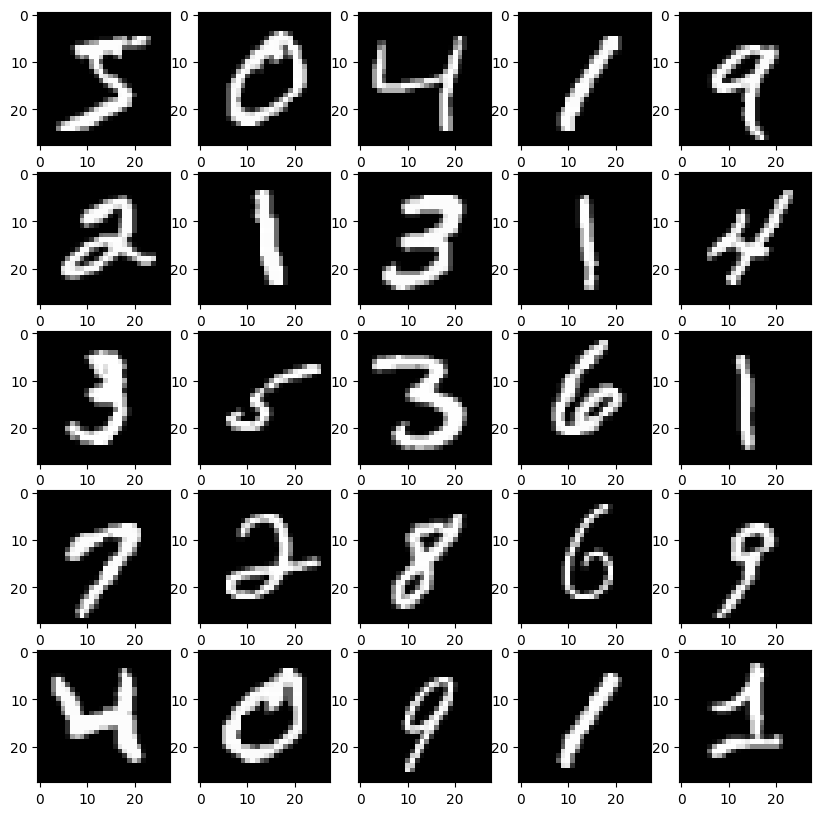

In [3]:
# посмотрим, что там у нас

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(all_digits[i], cmap=plt.cm.gray)
plt.show()

In [4]:
# представим картинки в виде, соответствующем
# свёрточному слою 28х28 пикселей с 1 каналом

all_digits = np.reshape(all_digits, (-1, 28, 28, 1))

# создадим датасет

dataset = tf.data.Dataset.from_tensor_slices(all_digits)

# картинки в датасете будут перемешиваться пачками по 1024
# и подаваться батчами по 64, при этом во время просчёта очередного батча
# следующие 32 картинки будут уже параллельно подготавливаться для ускорения работы

batch_size = 64
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

In [5]:
# создадим дискриминатор - свёрточную нейросеть для бинарной классификации картинок

discriminator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        
        # делаем последовательность свёрточных и pooling слоёв
        # параметр padding="same" задаёт паддинг таким образом, 
        # чтобы размер выходного слоя совпадал с предыдущим
        tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same"),
        
        # с Leaky ReLU наш GAN будет обучаться эффективнее
        tf.keras.layers.LeakyReLU(alpha=0.2),
        
        # ещё один такой же блок
        tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        
        # в конце выбираем максимальное значение среди всех в каждом канале
        tf.keras.layers.GlobalMaxPooling2D(),
        
        # и ставим полносвязный слой из 1 нейрона для классификации
        tf.keras.layers.Dense(1),
    ],
    
    name="discriminator",
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [6]:
# пусть эмбеддинг нашей картинки имеет размерность 128

latent_dim = 128

# создадим генератор

generator = tf.keras.Sequential(
    [
        # на вход получаем вектор из latent space
        tf.keras.Input(shape=(latent_dim,)),
        
        # прогоним его через Dense-слой, который потом можно будет развернуть в свёрточный
        tf.keras.layers.Dense(14 * 14 * 128),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        
        # переформируем слой в свёрточный 14х14 со 128 каналами
        tf.keras.layers.Reshape((14, 14, 128)),
        
        # используем "развёрточные" слои: они работают так же, 
        # как свёрточные, только в "обратную сторону"
        tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        
        # апсемплинг - пулинг наоборот
        # вместо одного пикселя генерируются 4 пикселя с таким значением
        tf.keras.layers.UpSampling2D(size=(2, 2)),
        
        # в конце генерируем картинку с одним каналом
        tf.keras.layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    
    name="generator",
)

In [7]:
# класс должен наследоваться от базового tf.keras.Model

class GAN(tf.keras.Model):
    # в конструкторе принимаем генератор и дискриминатор, указывая latent_dim
    def __init__(self, discriminator, generator, latent_dim):
        # для правильной работы модели необходимо вызвать конструктор родительского класса
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    # переопределим метод compile, чтобы была возможность задавать разные оптимизаторы
    # для обучения генератора и дискриминатора
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    # теперь главное: обучение
    # в методе train_step описывается, что происходит на каждом шаге обучения
    # нам на каждом шаге нужно сначала прогнать нагенерированные + реальные картинки
    # и обучить дискриминатор, а потом прогнать только нагенерированные и обучить генератор
    def train_step(self, real_images):
        # первое измерение - батч, оно нам не нужно
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        
        # размер батча будет определяться тем, сколько нам поступило настоящих картинок
        batch_size = tf.shape(real_images)[0]
        
        # генерируем такой же батч случайных нормально распределённых векторов из latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # прогоняем их через генератор, чтобы получить поддельные картинки
        generated_images = self.generator(random_latent_vectors)

        # в дискриминатор будем подавать их вместе с реальными (с соответствующими лейблами)
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # фейковым изображениям будет соответствовать 1, а настоящим - 0
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        # важный трюк при обучении GAN-ов - добавление случайного шума в лейблы
        # это позволит немного удержать дискриминатор от переобучения
        # уровень шума - это, конечно, тоже гиперпараметр
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # после того, как данные подготовлены, 
        # нужно сделать тренировочный шаг дискриминатора
        # для этого прогоняем их через дискриминатор и функцию потерь,
        # при этом нужно записать результаты вычислений в "ленту", объект GradientTape
        # после прямого прогона эту ленту можно будет как бы "размотать" в обратном порядке,
        # тем самым посчитав градиенты методом обратного распространения ошибки
        with tf.GradientTape() as tape:
            # получаем предсказания дискриминатора
            predictions = self.discriminator(combined_images)
            # и кладём их в функцию потерь, сравнивая с настоящими лейблами
            d_loss = self.loss_fn(labels, predictions)
        
        # теперь, используя нашу ленту, считаем градиенты от loss-функции до всех весов
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        
        # после того, как градиенты посчитаны, оптимизатор делает шаг в соовтетствующем направлении для всех весов
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # теперь пришло время обучить генератор
        # для этого снова сгенерируем батч векторов из latent_space, 
        # прогоним его через нашу сеть и сделаем шаг обучения генератора
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # наша цель - обмануть дискриминатор, поэтому помечаем
        # все картинки как "настоящие" (т.е. нулями)
        # если дискриминатор выдаст ноль (обманется), это хорошо, и loss Будет маленький
        # если же дискриминатор распознает фейк, loss будет большой, и это значит, нужно
        # сильнее обновить веса для данного примера
        misleading_labels = tf.zeros((batch_size, 1))

        # аналогичным образом проводим вычисления, записывая их в "ленту"
        with tf.GradientTape() as tape:
            # прогоняем наши вектора и через генератор, и через дискриминатор
            predictions = self.discriminator(self.generator(random_latent_vectors))
            # ответы подаём в loss-функцию
            g_loss = self.loss_fn(misleading_labels, predictions)
            
        # теперь вычисляем градиенты по весам генератора (дискриминатор обновлять не нужно)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        
        # делаем шаг оптимизатора по вычисленным градиентам (обновляем только веса генератора)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        return {"d_loss": d_loss, "g_loss": g_loss}


In [8]:
# создаём модель нашего GAN-а, как объект написанного нами класса

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

In [9]:
# компилируем
# обратите внимание, что можно использовать разные оптимизаторы
# для генератора и оптимизатора (но мы в обоих случаях используем одинаковые)

gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

In [10]:
# создадим папку images

import os

os.mkdir('images1')

In [11]:
# наследуем класс от базгового класса Callbak
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=5, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    # метод с таким названием Tensorflow будет вызывать в конце каждой эпохи
    def on_epoch_end(self, epoch, logs=None):
        # сгенерируем несколько случайных векторов
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        
        # и прогоним их через генератор, чтобы получить картинки
        generated_images = self.model.generator(random_latent_vectors)
        
        # отнормируем картинки и представим в numpy
        generated_images *= 255
        generated_images.numpy()
        
        # каждую картинку сохраним под определённым именем
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f"images1/{epoch}_img_{i}.png")

In [12]:
# коллбэк для сохранения промежуточных картинок
img_monitoring = GANMonitor(num_img=5, latent_dim=latent_dim)

epochs = 30

# метод fit будет делать шаги в соответствии с тем, 
# как мы описали их в методе train_step
gan.fit(dataset,  # в качестве обучающих данных передаём наш объект датасета, созданный ранее, он уже будет работать батчами
        epochs=epochs, 
        callbacks=[img_monitoring])

Epoch 1/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 313s 286ms/step - d_loss: 0.4214 - g_loss: 1.2864
Epoch 2/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 313s 287ms/step - d_loss: 0.6337 - g_loss: 1.0747
Epoch 3/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 309s 283ms/step - d_loss: 0.4648 - g_loss: 1.2123
Epoch 4/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 313s 286ms/step - d_loss: 0.3942 - g_loss: 1.6457
Epoch 5/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 310s 283ms/step - d_loss: 0.4410 - g_loss: 1.3079
Epoch 6/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 310s 283ms/step - d_loss: 0.3667 - g_loss: 1.5478
Epoch 7/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 311s 284ms/step - d_loss: 0.4104 - g_loss: 1.4842
Epoch 8/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 313s 286ms/step - d_loss: 0.3332 - g_loss: 1.4927
Epoch 9/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 311s 284ms/step - d_loss: 0.4467 - g_loss: 1.7848
Epoch 10/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 311s 284ms/step - d_loss: 0.3815 - g_loss: 1.4276
Epoch 11/30
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 312s 285ms/step - d_loss: 0.3614 - g

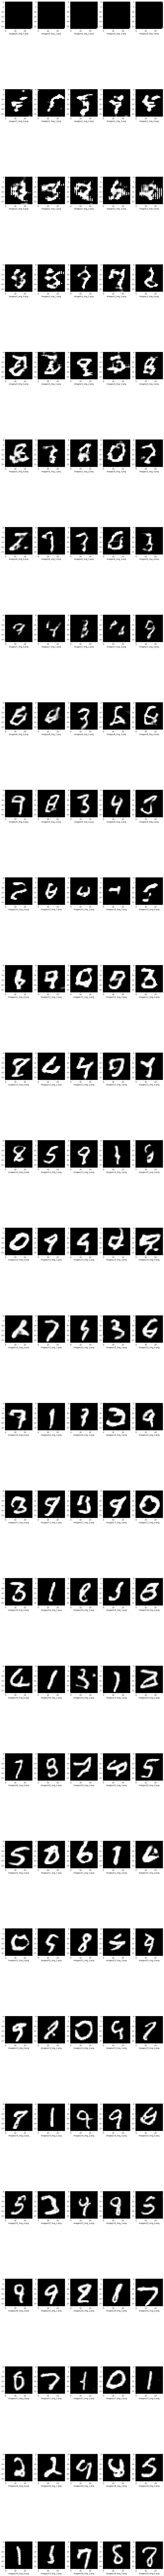

In [13]:
# посмотрим картинки, которые генерировались на каждой эпохе

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 250))
for epoch in range(epochs):
    for i in range(5):
        plt.subplot(epochs, 5, 5 * epoch + i + 1)
        img_name = 'images/' + str(epoch) + '_img_' + str(i) + '.png'
        img = tf.keras.preprocessing.image.load_img(img_name, target_size=(28, 28))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img.astype("float32") / 255
        plt.imshow(img, cmap=plt.cm.gray)
        plt.xlabel(img_name)
plt.show()

In [14]:
res = generator(tf.zeros(shape=(1, 128)))

In [17]:
img = tf.keras.preprocessing.image.array_to_img(res[0])
img.show()